In [1]:
import numpy as np
import glob
from scipy.optimize import curve_fit
import h5py

In [2]:
import os
os.chdir('Jupyter/SiPM/')

In [3]:
import matplotlib.pyplot as plt
plt.style.use('../../style.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
import sys
sys.path.insert(0, '../../../purity-monitor/')
sys.path.insert(0, '../../WaveformAnalysis/')

In [5]:
import Dataset as Dataset
import Waveform as Waveform
import SiPM as SiPM

In [6]:
import importlib
importlib.reload(Dataset)
importlib.reload(SiPM)
importlib.reload(Waveform)

<module 'Waveform' from '../../WaveformAnalysis/Waveform.py'>

In [7]:
Path = '/project/david_moore/dcm42/data/20220608/'

In [8]:
D0 = SiPM.SiPM(Path=Path, Selection='wavefms_keith_1.00OV*.h5')
D0.Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]

print(len(D0.Files))
for File in D0.Files[:20]:
    D0.ImportDataFromHDF5(File, D0.Ch, var=[])

1


In [9]:
for ii, ch in enumerate(D0.Ch):
    ch.Amp = ch.SubtractBaseline(Data=ch.Amp, cutoff=150, state=False)
    ch.GetAllMaxima(Data=ch.Amp, cutoff=1000, state=False)

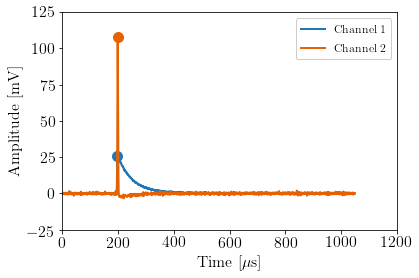

In [10]:
plt.figure()
for i,x in enumerate(D0.Ch[0].Amp[:1]):
    plt.plot(D0.Ch[0].Time, x, label='Channel 1')
    plt.scatter(D0.Ch[0].MaxT[i], D0.Ch[0].Max[i])
for x in D0.Ch[1].Amp[:1]:
    plt.plot(D0.Ch[1].Time, x, label='Channel 2')
    plt.scatter(D0.Ch[1].MaxT[i], D0.Ch[1].Max[i])
plt.xlabel('Time [$\mu$s]')
plt.ylabel('Amplitude [mV]')
plt.legend(loc='upper right')
plt.show() 

Let's get the voltage steps from the filenames

In [11]:
voltages = glob.glob(Path+'wave*')
voltages = [x.split('_')[-1] for x in voltages]
voltages = np.array(sorted([x.split('OV')[0] for x in voltages]))
print(voltages)

['1.00' '1.22' '1.44' '1.67' '1.89' '2.11' '2.33' '2.56' '2.78' '3.00']


Now we can loop over all files for the various voltages, save the data and run a simple analysis including baseline subtraction and maximum finding

In [12]:
Ds = {}
for volt in voltages: 
    Ds[volt] = SiPM.SiPM(Path=Path, Selection='wavefms_keith_{}OV*.h5'.format(volt))
    Ds[volt].Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]

    for File in Ds[volt].Files[:20]:
        Ds[volt].ImportDataFromHDF5(File, Ds[volt].Ch, var=[])
    for ii, ch in enumerate(Ds[volt].Ch):
        ch.Amp = ch.SubtractBaseline(Data=ch.Amp, cutoff=150, state=False)
        ch.GetAllMaxima(Data=[np.mean(ch.Amp,axis=0)], cutoff=500, state=False)

In [13]:
def line(x,a,b):
    return a*x+b

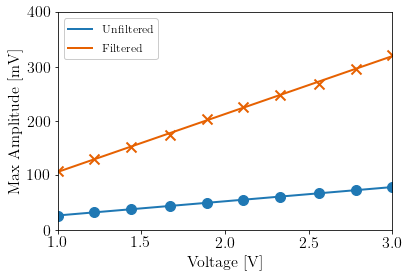

In [14]:
plt.figure()
plt.xlim(np.min(voltages.astype(float)), np.max(voltages.astype(float)))
plt.xlabel('Voltage [V]')
plt.ylabel('Max Amplitude [mV]')

ys = {}
ys[0] = []
ys[1] = []

for volt in voltages.astype(str): 
    markers = ['o', 'x']
    for i,ch in enumerate(Ds[volt].Ch):
        x = [float(volt)]*len(ch.Max)
        y = ch.Max
        ys[i].append(y[0])
        plt.scatter(x,y, marker=markers[i], color=colors[i])

xval = np.array([float(x) for x in voltages])
popt1,pcov1 = curve_fit(line, xval, np.array(ys[0]))      
popt2,pcov2 = curve_fit(line, xval, np.array(ys[1]))      

plt.plot(xval, line(xval,*popt1), label='Unfiltered')
plt.plot(xval, line(xval,*popt2), label='Filtered')
plt.legend(loc='upper left')
plt.show() 

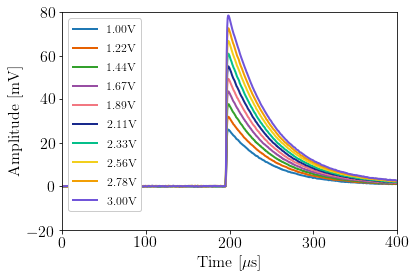

In [15]:
plt.figure() 
plt.xlim(0,400)
plt.xlabel('Time [$\mu$s]')
plt.ylabel('Amplitude [mV]')
for volt in voltages: 
    markers = ['o', 'x']
    for i,ch in enumerate(Ds[volt].Ch[:1]):
        plt.plot(Ds[volt].Ch[0].Time, np.mean(Ds[volt].Ch[0].Amp, axis=0), label='{}V'.format(volt))
plt.legend(loc='upper left', ncol=1)
plt.show() 

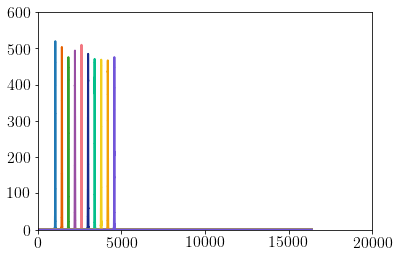

In [16]:
plt.figure()
ys = []
for volt in voltages:
    file1 = Path+'mca_keith_{}OV.h5'.format(volt)
    f = h5py.File(file1, 'r')  
    ch2 = f.get('ch2')
    for key in ch2.keys(): 
        data = np.array(ch2.get(key))
        plt.step(np.arange(0,len(data),1), data)
        ys.append(np.argmax(data))
    f.close()
plt.show()

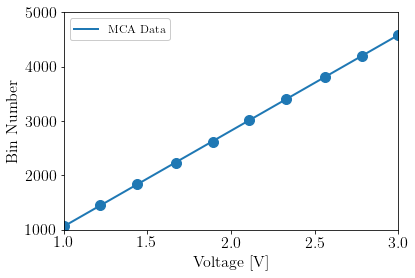

In [17]:
plt.figure()
plt.xlim(np.min(voltages.astype(float)), np.max(voltages.astype(float)))
plt.xlabel('Voltage [V]')
plt.ylabel('Bin Number')
plt.scatter(voltages.astype(float), ys)

popt,pcov = curve_fit(line,voltages.astype(float), ys)

plt.plot(voltages.astype(float), line(voltages.astype(float),*popt), label='MCA Data')
plt.legend(loc='upper left')
plt.show()